# FTRL (Follow The Regularized Leader)
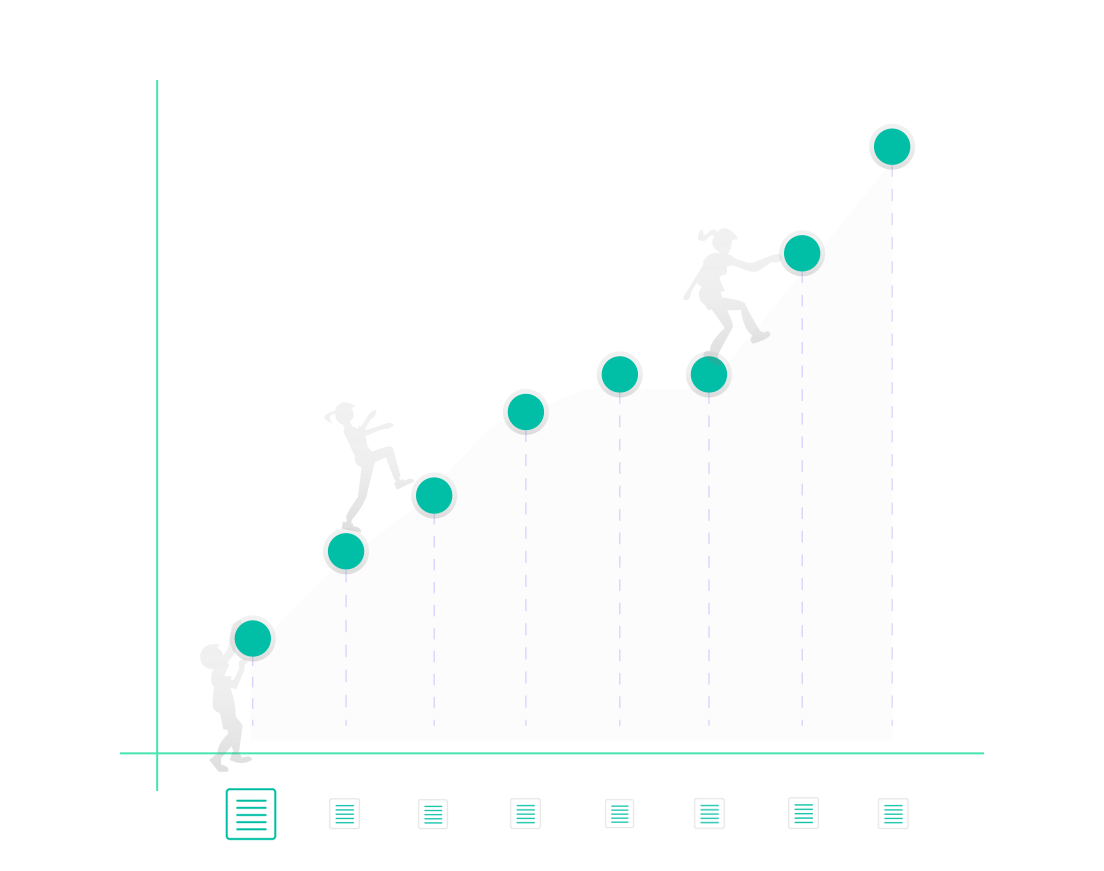

**FTRL** is an online learning algorithm used for binary classification tasks. It uses incremental learning sttategy for better performance.

Read more about FTRL [here](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/41159.pdf)

In [1]:
# installing datatable
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl

Processing /kaggle/input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl


In [2]:
## importing packages
import datatable as dt
import pandas as pd
import numpy as np
import pickle
import gc

from datatable.models import Ftrl
from sklearn.metrics import roc_auc_score

import riiideducation

## Loading data
Using the .feather format of the training data and converting it to datatable. The important features dataset is available [here](https://www.kaggle.com/abhimanyukarshni/riiid-train).


In [3]:
# reading data
df = pd.read_feather("../input/riiid-train/riiid_train.feather")
prior_question_elapsed_time_mean = df['prior_question_elapsed_time'].values.mean()
train = dt.Frame(df)
del df

In [4]:
# train data
train

<Frame#7fcc1d807090 96817414x11>

## Data Splitting

The first **95M** rows are used for training and rest **5M** for validation.


In [5]:
# preparing train and validation data
TARGET = 'answered_correctly'
FEATURES = ['content_id', 'prior_question_elapsed_time', 'prior_question_had_explanation',
 'answered_correctly_u_avg', 'explanation_u_avg', 'answered_correctly_q_avg',
 'explanation_q_avg', 'elapsed_time_q_avg', 'timestamp_u_recency_1']

y_train, y_valid = train[:95000000, TARGET], train[95000000:, TARGET]
X_train, X_valid = train[:95000000, FEATURES], train[95000000:, FEATURES]
del train

## FTRL Model
Datatable can be directly used to build an FTRL model. Documentation can be found [here](https://datatable.readthedocs.io/en/latest/manual/ftrl.html)

In [6]:
%%time
# building and validating FTRL model
model_ftrl = Ftrl(nepochs = 20) 

model_ftrl.fit(X_train, y_train, X_validation = X_valid, y_validation = y_valid, validation_error = 0.001)
y_pred = model_ftrl.predict(X_valid)
    
print(f"Validation AUC: {roc_auc_score(y_valid.to_numpy(), y_pred.to_numpy())}")

Validation AUC: 0.7582943725783806
CPU times: user 6min 57s, sys: 281 ms, total: 6min 57s
Wall time: 1min 48s


In [7]:
def dd():
    return defaultdict(int)

def save_obj(obj, name ):
    with open('./'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('../input/riiid-train/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Loading accumulated feature dictionaries

In [8]:
%%time
answered_correctly_u_count =  load_obj('answered_correctly_u_count')
answered_correctly_u_sum =  load_obj('answered_correctly_u_sum')
explanation_u_sum =  load_obj('explanation_u_sum')
timestamp_u =  load_obj('timestamp_u')
answered_correctly_q_count = load_obj('answered_correctly_q_count')
answered_correctly_q_sum = load_obj('answered_correctly_q_sum')
elapsed_time_q_sum = load_obj('elapsed_time_q_sum')
explanation_q_sum = load_obj('explanation_q_sum')

CPU times: user 2.56 s, sys: 417 ms, total: 2.98 s
Wall time: 3.55 s


In [9]:
def add_features(df, update = True):
    # -----------------------------------------------------------------------
    # Student features
    answered_correctly_u_avg = np.zeros(len(df), dtype = np.float32)
    explanation_u_avg = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_1 = np.zeros(len(df), dtype = np.float32)
    # -----------------------------------------------------------------------
    # Question features
    answered_correctly_q_avg = np.zeros(len(df), dtype = np.float32)
    explanation_q_avg = np.zeros(len(df), dtype = np.float32)
    elapsed_time_q_avg = np.zeros(len(df), dtype = np.float32)

    for num, row in enumerate(df[['user_id', 'answered_correctly', 'content_id', 'prior_question_had_explanation', 'timestamp', 'prior_question_elapsed_time']].values):
        
        # Student features assignation
        
        # Assigning values to average accuracy of the student, and % explanations seen by the student till now
        if answered_correctly_u_count[row[0]] != 0:
            answered_correctly_u_avg[num] = answered_correctly_u_sum[row[0]] / answered_correctly_u_count[row[0]]
            explanation_u_avg[num] = explanation_u_sum[row[0]] / answered_correctly_u_count[row[0]]
        else:
            answered_correctly_u_avg[num] = np.nan
            explanation_u_avg[num] = np.nan

        # Assigning values to time recencies which are time elapsed since last interaction   
        if len(timestamp_u[row[0]]) == 0:
            timestamp_u_recency_1[num] = np.nan
        elif len(timestamp_u[row[0]]) == 1:
            timestamp_u_recency_1[num] = row[4] - timestamp_u[row[0]][0]
        elif len(timestamp_u[row[0]]) == 2:
            timestamp_u_recency_1[num] = row[4] - timestamp_u[row[0]][1]
        elif len(timestamp_u[row[0]]) == 3:
            timestamp_u_recency_1[num] = row[4] - timestamp_u[row[0]][2]

        # Question features assignation
        # Assigning values to average accuracy, % explanations seen, and average time elapsed for the question till now
        if answered_correctly_q_count[row[2]] != 0:
            answered_correctly_q_avg[num] = answered_correctly_q_sum[row[2]] / answered_correctly_q_count[row[2]]
            elapsed_time_q_avg[num] = elapsed_time_q_sum[row[2]] / answered_correctly_q_count[row[2]]
            explanation_q_avg[num] = explanation_q_sum[row[2]] / answered_correctly_q_count[row[2]]
        else:
            answered_correctly_q_avg[num] = np.nan
            elapsed_time_q_avg[num] = np.nan
            explanation_q_avg[num] = np.nan

        # Flag for training and inference
        if update:
            # Student features updates
            answered_correctly_u_count[row[0]] += 1
            explanation_u_sum[row[0]] += int(row[3])
            if len(timestamp_u[row[0]]) == 3:
                timestamp_u[row[0]].pop(0)
                timestamp_u[row[0]].append(row[4])
            else:
                timestamp_u[row[0]].append(row[4])
            answered_correctly_u_sum[row[0]] += row[1]
            
            # Question features updates
            answered_correctly_q_sum[row[2]] += row[1]
            elapsed_time_q_sum[row[2]] += row[5]
            answered_correctly_q_count[row[2]] += 1
            explanation_q_sum[row[2]] += int(row[3])
        
    user_df = pd.DataFrame({'answered_correctly_u_avg': answered_correctly_u_avg, 'explanation_u_avg': explanation_u_avg, 
                            'answered_correctly_q_avg': answered_correctly_q_avg, 'explanation_q_avg': explanation_q_avg, 'elapsed_time_q_avg' : elapsed_time_q_avg, 
                            'timestamp_u_recency_1': timestamp_u_recency_1,})
    
    # Merging calculated features with the DataFrame
    df = pd.concat([df, user_df], axis = 1)
    return df

In [10]:
def update_features(df):
    for row in df[['user_id', 'answered_correctly', 'content_id', 'timestamp', 'prior_question_had_explanation', 'prior_question_elapsed_time']].values:
            # ------------------------------------------------------------------
            # Student features updates
            answered_correctly_u_count[row[0]] += 1
            answered_correctly_u_sum[row[0]] += row[1]
            explanation_u_sum[row[0]] += int(row[4])
            if row[1] == 0:
                if len(timestamp_u[row[0]]) == 3:
                    timestamp_u[row[0]].pop(0)
                    timestamp_u[row[0]].append(row[3])
                else:
                    timestamp_u[row[0]].append(row[3])

            # Question features updates
            answered_correctly_q_sum[row[2]] += row[1]
            answered_correctly_q_count[row[2]] += 1
            elapsed_time_q_sum[row[2]] += row[5]
            explanation_q_sum[row[2]] += int(row[4])
            
    return

## Inferencing and Incremental Learning
One of the great advantages of FTRL is the ability to perform **incremental learning**. What this really means is for every batch of newly available training data the model weights can be fine-tuned.

Since this is precisely how the test data will be made available from the API, we could easily perform inferencing and then incremental learning of each batch of new data that becomes available.

In [11]:
# initializing test environment
env = riiideducation.make_env()
iter_test = env.iter_test()

In [12]:
%%time
# inferencing and incremental learning
prev_test = None
for (test_df, sample) in iter_test:
    # extracting previous batch's targets
    prev_target = eval(test_df["prior_group_answers_correct"].iloc[0])
    # incremental learning
    if prev_test is not None:
        prev_test["answered_correctly"] = prev_target
        X_prev_test = dt.Frame(prev_test)
        # Getting x and y for incremental learning
        y_prev_test = X_prev_test[:, TARGET]
        X_prev_test = X_prev_test[:, FEATURES]
        # Training the model on test data batch
        model_ftrl.fit(X_prev_test, y_prev_test)
    # processing and adding features
    test_df['prior_question_had_explanation'] = test_df.prior_question_had_explanation.fillna(False).astype('int8')
    test_df['prior_question_elapsed_time'] = test_df.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    test_df['answered_correctly'] = 0
    test_df = add_features(test_df, update = False)
    X_test = dt.Frame(test_df[FEATURES])
    # passing through model to get preds
    test_df['answered_correctly'] = model_ftrl.predict(X_test).to_numpy().ravel()
    env.predict(test_df[['row_id', TARGET]])
    # retaining current batch data for next batch
    prev_test = test_df.copy(deep = True)

CPU times: user 524 ms, sys: 25.9 ms, total: 550 ms
Wall time: 367 ms
